In [3]:
import sys
sys.path.append("..")

In [4]:
import collections
from pathlib import Path
import json
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

from dataset.vqa import VQADataset,VQATorchDataset, VQAEvaluator

In [5]:
home = str(Path.home())
MSCOCO_IMGFEAT_ROOT = home + '/data/mscoco_imgfeat/'
VQA_DATA_ROOT = home+'/data/vqa/'

In [6]:
class Args():
    def __init__(self):
        self.tiny = True
        self.bs = 128
args = Args()

In [7]:
DataTuple = collections.namedtuple("DataTuple", 'dataset loader evaluator')

def get_data_tuple(path: str, mscoco_path: str, splits: str, tiny: bool,bs:int, shuffle=False, drop_last=False) -> DataTuple:
    dset = VQADataset(path,splits)
    tset = VQATorchDataset(dset,mscoco_path,tiny)
    evaluator = VQAEvaluator(dset)
    pin_memory = True if torch.cuda.is_available() else False
    data_loader = DataLoader(
        tset, batch_size=bs,
        shuffle=shuffle, num_workers=1,
        drop_last=drop_last, pin_memory=pin_memory
    )

    return DataTuple(dataset=dset,loader=data_loader, evaluator=evaluator)

train_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT, 'train,nominival', args.tiny, args.bs,True,True)
valid_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT,'minival',args.tiny,args.bs,True,True)

0it [00:00, ?it/s]

Load 632117 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


490it [00:02, 170.21it/s]
4it [00:00, 39.78it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


497it [00:02, 176.93it/s]


Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset



16it [00:00, 153.74it/s]

Load 25994 data from split(s) minival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


491it [00:02, 179.22it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2546 data in torch dataset



In [ ]:
dset = VQADataset(VQA_DATA_ROOT,'train,nominival')
tset = VQATorchDataset(dset,MSCOCO_IMGFEAT_ROOT,tiny=True)

0it [00:00, ?it/s]

Load 632117 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


484it [00:02, 171.87it/s]
19it [00:00, 188.56it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


494it [00:02, 182.59it/s]


Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset



In [ ]:
from models.lxmert_adaptive import VQAModel_Adaptive

I0511 18:41:03.772328 140157443386240 file_utils.py:38] PyTorch version 1.5.0 available.
/glob/intel-python/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glob/intel-python/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glob/intel-python/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

In [300]:
params = {'adapt_span_enabled': True, 'attn_span': 1024, 'adapt_span_loss_coeff': 0.000005, 
          'adapt_span_ramp': 32, 'adapt_span_init': 0.002, 'adapt_span_cache': True, 'nb_heads': 12,
          'bs': 128, 'mask_size': [20,36], 'sparse_enabled': False, 'num_attention_heads': 4, 
          'layer_sizes': {'lang':9,'cross':5,'vision':5}, 'from_scratch': False, 
          'layerdrop_enabled': False, 'layerdrop_num_layers': 1}

In [301]:
model = VQAModel_Adaptive(train_tuple[0].num_answers, params)

I0216 00:00:31.368615 139808573761344 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/u37216/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0216 00:00:31.770172 139808573761344 lxmert_utils.py:199] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0216 00:00:31.773823 139808573761344 lxmert_utils.py:207] extracting archive file /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /home/u37216/tmp/tmp62fag353
I0216 00:00:38.485806 139808

LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Using Adaptive Variant


In [303]:
ckpt = torch.load(home+'/snap/adaptive_6910.pth', map_location=torch.device('cpu'))
#ckpt = torch.load(home+'/snap/sparse_7.pth', map_location=torch.device('cpu'))
#ckpt = torch.load(home+'/snap/layerdrop_1066_ldrop_1.pth', map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

<All keys matched successfully>

In [208]:
#ques_id,feats,boxes,sent,target = next(iter(train_tuple[1]))

In [304]:
logit = model(feats,boxes,sent)

In [305]:
logit.shape

torch.Size([128, 3129])

In [306]:
score, label = logit.max(1) # max_val, index

In [307]:
score.shape, label.shape

(torch.Size([128]), torch.Size([128]))

In [308]:
score[0], label[0]

(tensor(1.4140, grad_fn=<SelectBackward>), tensor(3110))

In [309]:
dset = train_tuple[0]

In [310]:
for qid, l in zip(ques_id, label.cpu().numpy()):
    print(qid,l)
    break

tensor(186265001) 3110


In [311]:
quesid2ans = {}
for qid, l in zip(ques_id, label.cpu().numpy()):
    ans = dset.label2ans[l]
    quesid2ans[qid.item()] = ans

In [312]:
quesid2ans

{984000: 'banana',
 2093002: 'blue',
 2459002: '2',
 11025006: 'no',
 16037000: 'yes',
 33940002: 'left',
 46303000: 'no',
 50389003: 'bike',
 53672001: '6',
 53977006: 'bike',
 65195001: 'no',
 65195003: 'no',
 65916003: 'no',
 71621000: 'white',
 73460003: 'no',
 77902002: 'no',
 86221001: 'silver',
 89203000: 'right',
 95061031: 'no',
 96670009: 'no',
 101794000: 'brown',
 104397001: 'yes',
 105817004: '4',
 111040002: 'yes',
 111940003: '5',
 114363012: 'never',
 118806000: 'giraffe',
 121040000: '1',
 121040003: 'no',
 121235003: 'people',
 124069003: 'fedora',
 126096012: 'yes',
 126096014: 'kite',
 126096019: 'kite flying',
 126096029: 'string',
 126096040: 'many',
 131486001: 'yes',
 131952001: 'white',
 143777002: '1',
 147060003: 'man',
 149539001: 'boy',
 152557007: 'child',
 152557010: 'no',
 154625016: 'no',
 154625017: 'red',
 154625018: 'afternoon',
 158322005: 'no',
 158694007: 'very',
 164842002: 'skateboarding',
 182406003: 'no hat',
 182406006: 'grass',
 183040003: '

In [313]:
ans, qid.item()

('beach', 318190007)

In [314]:
idx_q =  353006002

In [315]:
qid = idx_q
ans = quesid2ans[idx_q]
ans

'talking'

In [316]:
splits = 'train,nominival'
path = VQA_DATA_ROOT
splits = splits.split(',')

In [317]:
data = []
for split in splits:
    data.extend(json.load(open(path+"%s.json" % split)))

In [318]:
main_idx = 0
for idx,i in enumerate(data):
    if i['question_id']==qid: #qid.item():
        print(idx)
        main_idx = idx

74051


In [319]:
data[main_idx]

{'answer_type': 'other',
 'img_id': 'COCO_train2014_000000353006',
 'label': {'talking': 1},
 'question_id': 353006002,
 'question_type': 'what is the man',
 'sent': 'What is the man on the monitor doing?'}

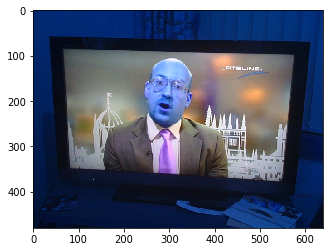

In [320]:
im = cv.imread(VQA_DATA_ROOT+'train'+'2014'+'/'+ data[main_idx]['img_id']+'.jpg')
im = plt.imshow(im)
im = plt.show()

## top k

In [321]:
logit[0].shape

torch.Size([3129])

In [322]:
scores_k, labels_k = torch.topk(logit, 5) 
labels_k.shape, scores_k.shape

(torch.Size([128, 5]), torch.Size([128, 5]))

In [323]:
quesid2ans_k = []
quesid2ans = {}
for i in range(len(labels_k)):
    qid = ques_id[i]
    ans = []
    for l in labels_k[i].cpu().numpy():
        #print(qid,l)
        ans.append(dset.label2ans[l])
        quesid2ans[qid.item()] = ans
    quesid2ans_k.append(quesid2ans) 

In [324]:
quesid2scores_k = []
quesid2scores = {}
for i in range(len(scores_k)):
    qid = ques_id[i]
    scores = []
    for l in scores_k[i].cpu().detach().numpy():
        scores.append(l)
        quesid2scores[qid.item()] = scores
    quesid2scores_k.append(quesid2scores) 

In [325]:
quesid2ans_k

[{984000: ['banana', 'bananas', 'fruit', 'food', 'oranges'],
  2093002: ['blue', 'brown', 'white', 'blue and white', 'gray'],
  2459002: ['2', '1', '3', '4', '5'],
  11025006: ['no', 'yes', 'tennis', 'not sure', '1'],
  16037000: ['yes', 'no', 'unknown', 'not sure', 'very'],
  33940002: ['left', 'right', 'to left', 'no', 'west'],
  46303000: ['no', 'yes', 'nothing', 'o', '2'],
  50389003: ['bike', 'bicycle', 'riding bike', 'biking', 'yes'],
  53672001: ['6', '5', '7', '4', '8'],
  53977006: ['bike', 'taxi', 'cart', 'car', 'bicycle'],
  65195001: ['no', 'yes', '1', 'nothing', 'left'],
  65195003: ['no', 'yes', 'not sure', 'unknown', "don't know"],
  65916003: ['no', 'yes', 'not sure', 'unknown', "don't know"],
  71621000: ['white', 'green', 'beige', 'cream', 'clear'],
  73460003: ['no', 'yes', 'nothing', 'unknown', 'not sure'],
  77902002: ['no', 'yes', '2', '0', '1'],
  86221001: ['silver', 'white', 'gray', 'silver and black', 'blue'],
  89203000: ['right', 'left', 'north', 'west', 'st

In [326]:
idx_q = 353006002

In [327]:
qid = idx_q
ans = quesid2ans[idx_q]
scores = quesid2scores[idx_q]
ans, scores

(['talking', 'watching', 'looking', 'sitting', 'smiling'],
 [-1.7269828, -1.8085332, -1.9110098, -2.1859527, -2.2824066])

In [95]:
# def label2ans(labels):
#     classes = []
#     for i in range(len(labels)):
#         classes.append(dset.label2ans[labels[i].item()])
#     return classes
# labels_k_str = label2ans(labels_k)

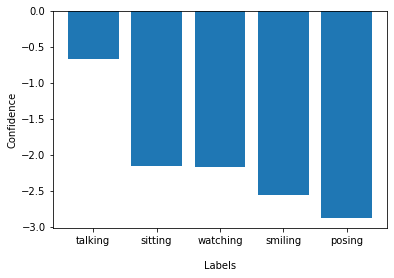

In [299]:
plt.bar(ans, scores)
#plt.subplot(211)
plt.xlabel('\nLabels')
plt.ylabel('Confidence')
plt.show()

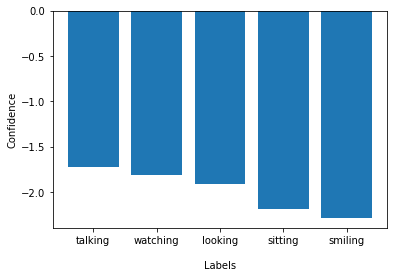

In [328]:
plt.bar(ans, scores)
plt.xlabel('\nLabels')
plt.ylabel('Confidence')
plt.show()

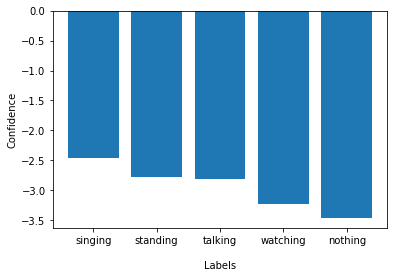

In [271]:
plt.bar(ans, scores)
plt.xlabel('\nLabels')
plt.ylabel('Confidence')
plt.show()